# End-to-end Semantic Deduplication on Text Data

GPU accelerated implementation of [SemDeDup: Data-efficient learning at web-scale through semantic deduplication](https://arxiv.org/abs/2303.09540)  

The tutorial here shows how to run Semantic Duplication on text data by executing a single workflow which does the following:

1. Read original dataset
2. Run embedding generation 
3. Use K-Means to cluster the embeddings
4. Compute pairwise similarity inside each of the clusters
5. Identify duplicates based on `eps` provided (and `ranking_strategy`)
6. Remove duplicates from the original dataset

We also allow users to also run these steps independently, which can be seen in the step by step tutorial in the same directory as this tutorial.


In [ ]:
import os

# Silence Curator logs via Loguru
os.environ["LOGURU_LEVEL"] = "ERROR"

import pandas as pd
import pyarrow.parquet as pq

input_path = os.path.abspath("./input")
semantic_out_dir = os.path.abspath("./output/e2e")
output_path = os.path.join(semantic_out_dir, "output")
cache_path = os.path.join(semantic_out_dir, "cache")
input_filetype = (
    "parquet"  # this can be either of jsonl or parquet (you'll need to change how input data is generated)
)
output_filetype = "parquet"  # this can be either of jsonl or parquet

## Generate Input Data

We generate input data if we don't have files in the path above
 - We load the [TinyStories](https://huggingface.co/datasets/roneneldan/TinyStories) dataset (just the train partition) which has 2,119,719 rows
 - We split into shards such that no shard has more than 10,000 rows
 - We create a new ID column which is UUID
 - We write out ~212 files

In [2]:
from nemo_curator.utils.file_utils import get_all_file_paths_under

if len(get_all_file_paths_under(input_path)) == 0:
    import os
    import uuid

    import numpy as np
    from datasets import load_dataset

    input_df = load_dataset("roneneldan/TinyStories", split="train").to_pandas()
    num_rows_per_file = 10_000

    os.makedirs(input_path, exist_ok=True)

    for i, start_idx in enumerate(range(0, len(input_df), num_rows_per_file)):
        end_idx = min(len(input_df), start_idx + num_rows_per_file)
        subset_df = input_df.iloc[start_idx:end_idx].copy()
        subset_df["id"] = [str(uuid.uuid4()) for _ in range(len(subset_df))]
        subset_df.to_parquet(os.path.join(input_path, f"part_{i}.parquet"), index=False)

    print(f"Created {len(os.listdir(input_path))} files")

## Running as a Single Stage (End-to-End)


### Performance Notes
Set `id_generator=True` if you want to remove duplicates from large datasets (i.e. when `perform_removal=True`).

- The ID Generator gives each row a unique increasing integer ID, based on the order files are read.
- When we find duplicates, we save these integer IDs in sorted files with multiple row groups.
- During removal, reading the same files will give the same integer IDs, using the min/max ID values, we can find all corresponding duplicates.
- This makes finding and removing duplicates much faster.

In [ ]:
from nemo_curator.stages.deduplication.semantic import RankingStrategy
from nemo_curator.stages.text.deduplication.semantic import TextSemanticDeduplicationWorkflow

workflow = TextSemanticDeduplicationWorkflow(
    input_path=input_path,
    output_path=output_path,
    cache_path=cache_path,
    perform_removal=True,
    # Embedding generation parameters
    text_field="text",
    model_identifier="sentence-transformers/all-MiniLM-L6-v2",
    embedding_max_seq_length=512,
    embedding_max_chars=None,
    embedding_pooling="mean_pooling",
    embedding_model_inference_batch_size=256,
    # Semantic deduplication parameters
    n_clusters=100,  # this number can be much higher when the data is large
    # For large scale data removal we should use CURATOR_DEDUP_ID_STR
    id_field="id",
    eps=0.01,
    # K-Means clustering parameters
    ranking_strategy=RankingStrategy(metadata_cols=["cosine_dist_to_cent"], ascending=True),
    pairwise_batch_size=1024,
    # ID generator parameters
    # For large scale data removal we should set use_id_generator to True
    use_id_generator=False,
    id_generator_state_file=None,
    # I/O parameters
    input_filetype=input_filetype,
    input_files_per_partition=1,
    output_filetype=output_filetype,
    verbose=True,
    clear_output=True,
)

In [ ]:
from nemo_curator.core.client import RayClient

# Number of GPUs should be roughly 2x the memory of the embeddings
client = RayClient(num_cpus=64, num_gpus=4)
client.start()
try:
    workflow.run()
finally:
    client.stop()

2025-09-17 14:51:14,215	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-17 14:51:14,218	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...


2025-09-17 14:51:15,316	INFO usage_lib.py:447 -- Usage stats collection is disabled.
2025-09-17 14:51:15,316	INFO scripts.py:913 -- Local node IP: 127.0.1.1


2025-09-17 14:51:18,326	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


2025-09-17 14:51:18,160	SUCC scripts.py:949 -- --------------------
2025-09-17 14:51:18,160	SUCC scripts.py:950 -- Ray runtime started.
2025-09-17 14:51:18,160	SUCC scripts.py:951 -- --------------------
2025-09-17 14:51:18,160	INFO scripts.py:953 -- Next steps
2025-09-17 14:51:18,160	INFO scripts.py:956 -- To add another node to this Ray cluster, run
2025-09-17 14:51:18,160	INFO scripts.py:959 --   ray start --address='127.0.1.1:6379'
2025-09-17 14:51:18,160	INFO scripts.py:968 -- To connect to this Ray cluster:
2025-09-17 14:51:18,160	INFO scripts.py:970 -- import ray
2025-09-17 14:51:18,160	INFO scripts.py:971 -- ray.init(_node_ip_address='127.0.1.1')
2025-09-17 14:51:18,160	INFO scripts.py:983 -- To submit a Ray job using the Ray Jobs CLI:
2025-09-17 14:51:18,160	INFO scripts.py:984 --   RAY_API_SERVER_ADDRESS='http://127.0.0.1:8265' ray job submit --working-dir . -- python my_script.py
2025-09-17 14:51:18,160	INFO scripts.py:993 -- See https://docs.ray.io/en/latest/cluster/running

2025-09-17 14:51:19,400	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-17 14:51:19,401	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-17 14:51:19,401	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 20223.26it/s]
2025-09-17 14:54:34,118	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-17 14:54:34,120	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-17 14:54:34,129	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


(KMeansReadFitWriteStage pid=1184855) 203412096
(KMeansReadFitWriteStage pid=1184857) 203520000
(KMeansReadFitWriteStage pid=1184856) 203520000
(KMeansReadFitWriteStage pid=1184858) 203520000


2025-09-17 14:55:08,160	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-17 14:55:08,161	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-17 14:55:08,168	INFO worker.py:1942 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 
2025-09-17 14:55:08,183	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-17 14:55:08,185	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-17 14:55:08,185	INFO worker.py:1789 -- Calling ray.init() again after it has already been called.
2025-09-17 14:55:36,596	INFO worker.py:1630 -- Using address 127.0.1.1:6379 set in the environment variable RAY_ADDRESS
2025-09-17 14:55:36,598	INFO worker.py:1771 -- Connecting to existing Ray cluster at address: 127.0.1.1:6379...
2025-09-17 14:55:36,607	INFO worker.py:1942 -- Connected to Ray cluster. View th

### Looking at Intermediate Results and Output

#### 1. Embeddings Results

1. `id` : The ID field from our original dataset. 
    - For all subsequent steps this is assumed to be the  `id_field`.
    - If you had set `use_id_generator` to `True` then instead of this you would see the `_curator_dedup_id` specified. 
        - The ID in that field is generated using our `IdGenerator` which assigns integer IDs to each row in the input data that later is used for removal. 
2. `embeddings` : The embedding generated by the model we used above.

In [5]:
embeddings_path = os.path.join(cache_path, "embeddings")

pd.read_parquet(os.path.join(embeddings_path, os.listdir(embeddings_path)[0])).head()

,id,embeddings
0,d079fca9-d29b-4dbb-9ad1-21c667151bde,"[-0.12394736707210541, 0.010744917206466198, 0..."
1,d5bb9128-2e2b-4499-9898-46e2c2059ab2,"[-0.07273813337087631, 0.06685175746679306, 0...."
2,240d44a9-52aa-4197-a440-7d3aa88d8182,"[-0.04823765903711319, 0.11327654868364334, -0..."
3,690365e4-380b-4f63-9c75-4eb5fc5affa6,"[-0.08059918135404587, 0.024182168766856194, -..."
4,15a0dc0c-fd96-44b3-9d41-a42441a979b4,"[-0.031761009246110916, 0.02613956294953823, 0..."


#### 2. K-Means Results

1. `id` : The IDs of the rows that belong to the cluster.
2. `embeddings` : These are later used for pairwise similarity.
3. `l2_dist_to_cent` / `cosine_dist_to_cent` : This represents how far (l2 distance or cosine distance) a sample is from our cluster's centroid.
    - These fields help us define how we want to prioritize ranking within our cluster. See `RankingStrategy`
    - If we had other `metadata_fields` provided they would be used here instead.


In [6]:
kmeans_path_first_centroid = os.path.join(cache_path, "semantic_dedup", "kmeans_results", "centroid=0")

pd.read_parquet(os.path.join(kmeans_path_first_centroid, os.listdir(kmeans_path_first_centroid)[0])).head()

,id,embeddings,l2_dist_to_cent,cosine_dist_to_cent
0,9b4feddc-4d51-43fb-aeaa-18024a32d60c,"[-0.051341612, 0.023956891, 0.0818636, 0.01455...",0.564844,0.174446
1,988c12f1-4adc-4123-a1ea-872818bed68b,"[-0.029556809, 0.040268984, 0.13631389, -0.001...",0.677120,0.261456
2,e8e4342d-2bed-4626-bd9e-222d0e347567,"[-0.08078232, 0.032830615, 0.10732673, -0.0177...",0.545969,0.161363
3,cffd02df-29d3-4d4d-9d19-332527f372d8,"[-0.016866645, 0.03228915, 0.021343842, 0.0527...",0.599426,0.199569
4,f3dd6532-0abf-4ad9-bca7-514d78085a8f,"[-0.04058464, 0.023736855, 0.09525293, 0.05758...",0.553145,0.166284


#### 3. Pairwise Similarity Result

1. `id` : The identifier for the duplicate row.
2. `max_id` : The closest pair for the duplicate row.
3. `cosine_sim_score` : The cosine similarity between the two points.


In [7]:
pairwise_path = os.path.join(cache_path, "semantic_dedup", "pairwise_results")

pd.read_parquet(os.path.join(pairwise_path, "cluster_0.parquet")).head()

,id,max_id,cosine_sim_score
0,b6c8eb2e-bd73-4492-a927-f52d96c7a967,b6c8eb2e-bd73-4492-a927-f52d96c7a967,0.000000
1,e348775f-27bc-4ad2-b772-bd8d490c6af4,b6c8eb2e-bd73-4492-a927-f52d96c7a967,0.932138
2,9989bc6c-ed4c-43a1-9819-5c2cb137f736,b6c8eb2e-bd73-4492-a927-f52d96c7a967,0.936246
3,70314669-7849-4f71-aabb-6af954e80c42,b6c8eb2e-bd73-4492-a927-f52d96c7a967,0.915550
4,dd2ec313-2904-43dd-a522-8d643b492a05,b6c8eb2e-bd73-4492-a927-f52d96c7a967,0.928383


#### Looking at Similar Results

We can look at two rows and see why the embedding model thinks they're similar.
We can use this to guide our decision about the `eps` parameter.

We use two `9989bc6c-ed4c-43a1-9819-5c2cb137f736` and	`b6c8eb2e-bd73-4492-a927-f52d96c7a967` which have cosine similarity of	`0.936246`.

And we notice that the theme of the data is very similar. 

**NOTE: If you run with `use_id_generator=True` (which is important to perform removal at large scale) you will see the IDs which were generated internally, and there won't be a way to perform this step, as there is no simple way of getting the old mappings of IDs to the new mappings of IDs.**

In [9]:
from pprint import pprint

pprint(
    pd.read_parquet(
        input_path,
        filters=[("id", "in", {"9989bc6c-ed4c-43a1-9819-5c2cb137f736", "b6c8eb2e-bd73-4492-a927-f52d96c7a967"})],
    ).to_dict(orient="records")
)

[{'id': '9989bc6c-ed4c-43a1-9819-5c2cb137f736',
  'text': 'Once upon a time, there was a little girl named Lily. She loved to '
          'play outside in the lovely sunshine. One day, she went to the park '
          'with her mommy. They walked on the ground and saw many flowers.\n'
          '\n'
          'Lily saw a boy playing with a ball. She wanted to play too, but she '
          'was shy. Her mommy told her to ask the boy if she could play. Lily '
          'was nervous, but she asked the boy if she could play with him. The '
          'boy just shrugged and said "okay".\n'
          '\n'
          'Lily and the boy played together and had lots of fun. They kicked '
          'the ball and ran around. When it was time to go home, Lily said '
          "goodbye to the boy. As they walked away, Lily's mommy told her that "
          'it was good she asked to play. Lily smiled and felt happy. She knew '
          'she would always remember that lovely day at the park.'},
 {'id':

##### Visualizing Similarity in the Dataset


Depending on our dataset size we can read through all of the files and plot how much data is similar to one another.
Here we show how to read file by file and then perform a reduce. 

In our dataset we can see that ~20% of our data has cosine similarity of 0.9 or more.

Based on the analysis here and above (where we see similar text fields) we can decide what our `eps` should be. 

Note that in this tutorial we pre-ran with `eps` set and `perform_removal` as `True`.

Ideally, users do this analysis, inspect the duplicates, come up with an `eps`, run a pipeline that includes the `IdentifyDuplicates` stage, and finally perform removal.

In [10]:
from collections import Counter
from functools import reduce

import numpy as np


def get_bins(df: pd.DataFrame, num_bins: int = 1_000) -> dict[float, int]:
    bins = np.linspace(0, 1.01, num_bins)

    return Counter(
        pd.cut(df["cosine_sim_score"], bins=bins, labels=bins[1:], retbins=False, include_lowest=True, right=True)
        .value_counts()
        .to_dict()
    )


similarity_across_dataset = reduce(
    lambda x, y: x + y,
    [
        get_bins(pd.read_parquet(os.path.join(pairwise_path, f), columns=["cosine_sim_score"]), num_bins=1000)
        for f in os.listdir(pairwise_path)
    ],
)

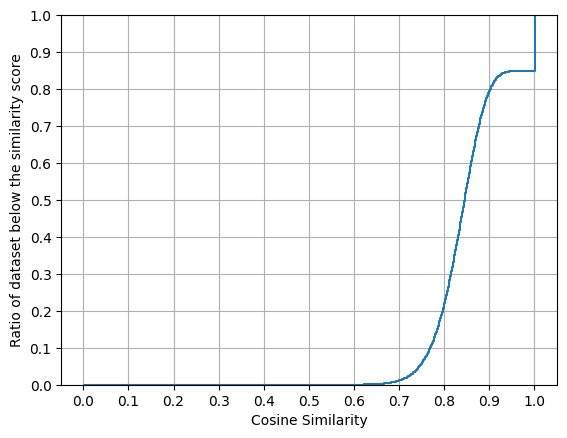

In [11]:
import matplotlib.pyplot as plt

plt.ecdf(x=similarity_across_dataset.keys(), weights=similarity_across_dataset.values())
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.xlabel("Cosine Similarity")
plt.ylabel("Ratio of dataset below the similarity score")
plt.grid()
plt.show()

#### Looking at Duplicates

- `id` : This is a list of all IDs that are above our similarity threshold `eps`.

In [12]:
duplicates_path = os.path.join(output_path, "duplicates")

pd.read_parquet(os.path.join(duplicates_path, os.listdir(duplicates_path)[0])).head()

,id
0,00031354-7148-4513-af11-4c93c73db7ba
1,0003de98-af44-4181-8ff5-9c8d86be8b96
2,0004215a-4560-4f23-9fbb-7e63b7a78be9
3,00065e09-b164-48ac-80fc-e4fd7a760c47
4,000d15ff-1f2e-4f21-974f-e2e9d4d96578


In [13]:
num_duplicates = sum(pq.read_metadata(os.path.join(duplicates_path, f)).num_rows for f in os.listdir(duplicates_path))
print(f"We found {num_duplicates:,} duplicates in the dataset")

We found 320,467 duplicates in the dataset


#### Looking at the Deduplicated Dataset

Here we see all the original columns. 

We can control the schema of this by specifying the `output_fields` argument in the workflow definition.

If you had set `use_id_generator=True` then you'd see `_curator_dedup_id` here as well.

In [14]:
deduplicated_path = os.path.join(output_path, "deduplicated")

pd.read_parquet(os.path.join(deduplicated_path, os.listdir(deduplicated_path)[0])).head()

,text,id
0,"Once upon a time, there was a big dog named Ma...",ad9623c1-e820-417b-a894-8ac327a63781
1,"Once upon a time, there was a shy little girl ...",d2857534-6995-4c30-b06f-bb842f683601
2,"Once upon a time, there was a little boy named...",0fe524d8-ca21-4c04-b344-9af8015f52e1
3,"Once upon a time, there was a little girl name...",87222f54-fc70-4f93-825f-5f0e59c4e070
4,"Once upon a time, there was a little girl name...",1d239f39-f5da-4573-bb52-9bb37e928a13


In [15]:
num_deduplicated = sum(
    pq.read_metadata(os.path.join(deduplicated_path, f)).num_rows for f in os.listdir(deduplicated_path)
)
print(f"Our final dataset has {num_deduplicated:,} rows")

Our final dataset has 1,799,252 rows


### Conclusion

We see we were able to remove ~320k duplicates from our dataset of 2.1 million rows using a single workflow.